This notebook will cover the data aggregration and cleaning of all the review text in preparation for modeling, as well as initial exploratory data analysis.

# Text Preprocessing:

- Natural Language Processing (NLP) requires a lot of text preprocessing and cleaning before any modeling begins. This is the most crucial step in determining the quality of output.
- Initial preprocessing includes removing unnecessary characters, and spacing. 
- The bulk of the processing will involve tokenizing sentences into words, removing stopwords, part-of-speech tagging, and stemming/lemmatizing words.

#### Import necessary packages:

In [45]:
import pandas as pd
import re
import glob
import pickle

import nltk
from sklearn.feature_extraction.text import CountVectorizer
from gensim import corpora
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models.ldamodel import LdaModel
from gensim.test.utils import datapath
import spacy # python -m spacy download en_core_web_sm
import en_core_web_sm

import plotly.graph_objs as go
import chart_studio.plotly as py
import cufflinks # !pip install ipywidgets for cufflinks to work
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')
import plotly.figure_factory as ff
from plotly.offline import iplot
import bokeh

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

### Assembling the base dataframe:

Earlier, we developed a web scraping script that was able to capture reviews from glassdoor and save them as separate csv files (~40 hours of webscraping to obtain all the data!). We can use glob to combine all the company review csv files into a single dataframe:

In [2]:
# read in all .csv files in our data folder
path = '../data/reviews'
files = [f for f in glob.glob(path + "**/*.csv", recursive=True)]

# using pandas to assemble individual DFs and combine together
li = [pd.read_csv(f) for f in files]
all_reviews = pd.concat(li, axis=0, ignore_index=True, sort=True) # sort=True b/c columns are in diff orders per df
all_reviews = all_reviews.drop(columns = ['Unnamed: 0','Unnamed: 0.1'])
all_reviews = all_reviews.dropna()
all_reviews.reset_index(drop=True, inplace=True)

# save output
all_reviews.to_csv('../../all_reviews_glob.csv')

In [3]:
# all_reviews = pd.read_csv('../../all_reviews.csv').drop(columns = ['Unnamed: 0'])
all_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258358 entries, 0 to 258357
Data columns (total 5 columns):
company    258358 non-null object
cons       258358 non-null object
pros       258358 non-null object
rating     258358 non-null float64
title      258358 non-null object
dtypes: float64(1), object(4)
memory usage: 9.9+ MB


- As we can see, there are 258,358 total company reviews with no null values present.
- We still need to clean our text by removing line endings, unwanted spaces, and special characters

In [4]:
# remove line endings and spaces contained in the HTML (i.e. "/n /r")
all_reviews.pros = all_reviews.pros.map(lambda x: re.sub('\s+', ' ', x))
all_reviews.cons = all_reviews.cons.map(lambda x: re.sub('\s+', ' ', x))
# remove special characters and lowercase all text
all_reviews.title = all_reviews.title.map(lambda x: re.sub('[^a-zA-Z0-9 \n\.]', '', str(x).lower()))
all_reviews.pros = all_reviews.pros.map(lambda x: re.sub('[^a-zA-Z0-9 \n\.]', '', x.lower()))
all_reviews.cons = all_reviews.cons.map(lambda x: re.sub('[^a-zA-Z0-9 \n\.]', '', x.lower()))

In [5]:
all_reviews.head(10)

,company,cons,pros,rating,title
0,3M,support function often with the ability to say...,broad exposure to businesses across company.,4.0,senior financial analyst
1,3M,as so many people work at 3m for their entire ...,flexible work schedule great people most salar...,4.0,people work at 3m forever
2,3M,regular cons that come up with working at big ...,diversity of projects and products enable to k...,4.0,corporate research analytical lab cral
3,3M,3m lifers can be shortsighted and dont appreci...,emphasis on technical ladder for engineers... ...,5.0,best place to work by a long shot
4,3M,big company bureaucracy can sometimes slow dec...,highly talented and diverse technical team dri...,5.0,3m great culture for new engineers
5,3M,i cant really think of any.,great company to work for. wonderful work flex...,5.0,3m a world class organizaton endless possibi...
6,3M,diversity isnt the strongest but theyre workin...,great culture everyone helps one another to s...,5.0,great culture great pay best entry job out of ...
7,3M,there are no cons working at 3m,innovative company. flexible in how employees ...,5.0,the best place to work
8,3M,very much a upper midwest mentality,decent company to work for,4.0,manager
9,3M,competitive pay could use some work,flexible schedule great opportunities to learn...,4.0,overall best place ive worked.


### Preprocessing Functions:
Below, we will define functions that will aid in preprocessing our data:

In [38]:
# Regex and tokenizing text:
# takes text, removes special characters and punctuation 
# and returns a list of lower-cased tokenized words
def tokenize_sentences(text):
    pattern = "([a-zA-Z]+(?:'[a-z]+)?)" 
    raw_tokens = nltk.regexp_tokenize(text, pattern)
    return [token.lower() for token in raw_tokens]

# Removing stopwords:
# removes stopwords from pre-tokenized list of words
def remove_stopwords(token_list, custom_words= []):
    return [word for word in token_list if word not in stopwords.words('english')+custom_words]

# Joining a list of words together
def join_word_list(word_list):
    return " ".join(word_list)

# Creating part-of-speech tags
# input is a string
# output is a list of tuples [('I', 'PRON'),('went', 'VERB'),('to', 'ADP'),('the', 'DET'),('store', 'NOUN'),('today', 'NOUN')]
def create_pos_tokens(review):
    doc = nlp(review)
    pos_tag_list = [(token.text, token.pos_) for token in doc]
    return pos_tag_list

In [7]:
# returns most frequent words in corpus
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(ngram_range=(1, 1), stop_words=stopwords.words('english')+custom_stopwords).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

# returns most frequent bigrams in corpus
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words=stopwords.words('english')+custom_stopwords).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

# returns most frequent trigrams in corpus
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words=stopwords.words('english')+custom_stopwords).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

### Tokenization:
Below, the sentences in each review are being separated into distinct words. This is called "tokenization."

In [8]:
tokenized_pros = all_reviews.pros.apply(lambda x: tokenize_sentences(x))
# preview
tokenized_pros[:3]

0    [broad, exposure, to, businesses, across, comp...
1    [flexible, work, schedule, great, people, most...
2    [diversity, of, projects, and, products, enabl...
Name: pros, dtype: object

In [9]:
tokenized_cons = all_reviews.cons.apply(lambda x: tokenize_sentences(x))
# preview
tokenized_cons[:3]

0    [support, function, often, with, the, ability,...
1    [as, so, many, people, work, at, m, for, their...
2    [regular, cons, that, come, up, with, working,...
Name: cons, dtype: object

### Removing Stopwords:
Stopwords are commonly occuring words in written vocabulary and are usually removed to negate the influence of words such as "and," "the," and "to." These are words that are frequently mentioned but offer limited information in understanding the meaning of a sentence. I have added custom stopwords that are frequently mentioned in our corpus due to just being the name of the company the review is written about.

In [10]:
# nltk.download('stopwords')
from nltk.corpus import stopwords

In [27]:
custom_stopwords = ['home', 'depot', 'verizon', 'boa', 'bank', 'america', 'boeing', 'comcast', 'ge', 'google', 'jp', 'morgan', 'microsoft', 'kroger', 'walgreens', 'wells', 'fargo']

In [16]:
# token list without stop words
tokenized_pros = tokenized_pros.apply(lambda x: remove_stopwords(x, custom_stopwords))
# preview
tokenized_pros[:3]

0       [broad, exposure, businesses, across, company]
1    [flexible, work, schedule, great, people, sala...
2    [diversity, projects, products, enable, keep, ...
Name: pros, dtype: object

In [13]:
# token list without stop words
tokenized_cons = tokenized_cons.apply(lambda x: remove_stopwords(x, custom_stopwords))
# preview
tokenized_cons[:3]

0    [support, function, often, ability, say, proje...
1    [many, people, work, entire, career, coming, m...
2    [regular, cons, come, working, big, companies,...
Name: cons, dtype: object

In [28]:
# pros_sentences = [' '.join(sentence) for sentence in tokenized_pros]
# cons_sentences = [' '.join(sentence) for sentence in tokenized_cons]

# Or use defined function (output is Series instead of a list):
pros_sentences = tokenized_pros.map(lambda x: join_word_list(x))
cons_sentences = tokenized_cons.map(lambda x: join_word_list(x))
# preview
pros_sentences[:10]

0             broad exposure businesses across company
1    flexible work schedule great people salaried p...
2    diversity projects products enable keep engage...
3    emphasis technical ladder engineers dont manag...
4    highly talented diverse technical team driven ...
5    great company work wonderful work flexibility ...
6    great culture everyone helps one another succe...
7    innovative company flexible employees approach...
8                                  decent company work
9    flexible schedule great opportunities learn al...
Name: pros, dtype: object

In [47]:
# save tokenized words using pickle
with open('../saved_objects/tokenized_pros.pkl', 'wb') as f:
    pickle.dump(tokenized_pros, f)
with open('../saved_objects/tokenized_cons.pkl', 'wb') as f:
    pickle.dump(tokenized_cons, f)

### Part-of-speech Tagging:
POS tagging allows us to isolate certain words by part of speech. If we want, we can choose to examine only nouns, adjectives, or verbs, for example.

In [40]:
# import spacy
# import en_core_web_sm
nlp = en_core_web_sm.load()

In [41]:
# use subset of dataframe since this process is intensive
subset_pros = pros_sentences.sample(10000)
subset_cons = cons_sentences.sample(10000)
# convert the series of pros/cons to pos-tagged tokens

# preview the series:
print(subset_pros[:5],'\n','\n', subset_cons[:5])

222597    good benefits compared companies ive worked co...
196155    flexible work timings good place people look c...
254739    company strong lot job security overall workin...
232680    part history embark new health care delivery s...
60242     great environment work amazing benefits great pay
Name: pros, dtype: object 
 
 218614    company literally absolutely nothing pay emplo...
112957    salaries may top industry workload intense dep...
25965     many list would probably say times intense pha...
107582    pay could better retail company didnt offer em...
163542    benefits tripped bit recently mostly medical m...
Name: cons, dtype: object


In [42]:
postag_pros_sentences = subset_pros.apply(lambda x: create_pos_tokens(x))
postag_cons_sentences = subset_cons.apply(lambda x: create_pos_tokens(x))
# preview
postag_pros_sentences[:5]

222597    [(good, ADJ), (benefits, NOUN), (compared, VER...
196155    [(flexible, ADJ), (work, NOUN), (timings, NOUN...
254739    [(company, NOUN), (strong, ADJ), (lot, NOUN), ...
232680    [(part, NOUN), (history, NOUN), (embark, VERB)...
60242     [(great, ADJ), (environment, NOUN), (work, NOU...
Name: pros, dtype: object

In [43]:
pros_adjs = postag_pros_sentences.apply(lambda x: [word[0] for word in x if word[1] == 'ADJ'])
cons_adjs = postag_cons_sentences.apply(lambda x: [word[0] for word in x if word[1] == 'ADJ'])
# preview
pros_adjs[:5]

222597                                [good, great, recent]
196155                               [flexible, good, core]
254739    [strong, retail, closer, great, great, good, g...
232680                                                [new]
60242                               [great, amazing, great]
Name: pros, dtype: object

In [44]:
joined_pros_adjs = pros_adjs.apply(lambda x: ' '.join(x))
joined_cons_adjs = cons_adjs.apply(lambda x: ' '.join(x))
# preview
joined_pros_adjs[:5]

222597                                    good great recent
196155                                   flexible good core
254739    strong retail closer great great good great fu...
232680                                                  new
60242                                   great amazing great
Name: pros, dtype: object

In [48]:
# save POS tagged words using pickle
with open('../saved_objects/postag_pros.pkl', 'wb') as f:
    pickle.dump(postag_pros_sentences, f)
with open('../saved_objects/postag_cons.pkl', 'wb') as f:
    pickle.dump(postag_cons_sentences, f)

### Stemming:
We can stem/lemmatize words in order to reduce multiple tenses of word to their root prefix. For example, the word "run" and "running" capture the same meaning for our purposes. Stemming the word "running" would reduce it to "run."

In [50]:
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer("english")

In [51]:
# preview
tokenized_pros[:5]

0       [broad, exposure, businesses, across, company]
1    [flexible, work, schedule, great, people, sala...
2    [diversity, projects, products, enable, keep, ...
3    [emphasis, technical, ladder, engineers, dont,...
4    [highly, talented, diverse, technical, team, d...
Name: pros, dtype: object

In [52]:
stemmed_pros = tokenized_pros.apply(lambda x: ' '.join([stemmer.stem(word) for word in x]))
stemmed_cons = tokenized_cons.apply(lambda x: ' '.join([stemmer.stem(word) for word in x]))
print(stemmed_pros[:5], '\n', '\n', stemmed_cons[:5])

0                    broad exposur busi across compani
1    flexibl work schedul great peopl salari peopl ...
2    divers project product enabl keep engag year y...
3    emphasi technic ladder engin dont manag get mo...
4    high talent divers technic team driven develop...
Name: pros, dtype: object 
 
 0    support function often abil say project abil d...
1    mani peopl work entir career come midcar outsi...
2    regular con come work big compani hard seen so...
3    lifer shortsight dont appreci rare though plac...
4    big compani bureaucraci sometim slow decis mak...
Name: cons, dtype: object


In [53]:
# save stemmed words objects using pickle
with open('../saved_objects/stemmed_prospkl', 'wb') as f:
    pickle.dump(stemmed_pros, f)
with open('../saved_objects/stemmed_cons.pkl', 'wb') as f:
    pickle.dump(stemmed_cons, f)

# Initial Exploratory Data Analysis

## Word Frequency Distributions:
Just to get an initial sense of the type of words and text contained in the reviews, we can look at word frequency counts. We can see which words are most frequently used among Pros and Cons, and across the entire corpus as a whole.

In [54]:
from nltk import FreqDist

In [64]:
all_cons = []
for record in tokenized_cons:
    all_cons += record
    
all_pros = []
for record in tokenized_pros:
    all_pros += record

In [58]:
# freq dist for all cons and all pros combined
freqdist_all = FreqDist(all_cons+all_pros)
# freq dist for pros and cons separately
freqdist_pros = FreqDist(all_pros)
freqdist_cons = FreqDist(all_cons)

### Most commonly used words across all reviews:

Let's take a look at the commonly used words in Fortune 100 company reviews.

In [65]:
# most common words in all reviews (pros+cons)
# hard to extract general sentiment from just words. Will probably need to include
    # bi-grams, tri-grams, and POS-tags for adjectives
freqdist_all.most_common(15)

[('work', 150174),
 ('good', 111301),
 ('great', 111282),
 ('company', 91301),
 ('benefits', 83722),
 ('people', 72005),
 ('management', 65245),
 ('pay', 63965),
 ('get', 49394),
 ('employees', 44510),
 ('time', 43931),
 ('job', 40462),
 ('hours', 39772),
 ('environment', 31580),
 ('working', 30826)]

Most of the words here are unsurprising, like "work," "good," "great," and "company." The words that particularly stand out and give us some insight into what employees value are "benefits," "pay," "hours," and "management." It's not completely unsurprising that these words are popular among job reviews. However, it validates our assumption that these are common aspects of a job that factor into an employee's overall level of satisfaction.

### Most commonly used words among "Pros" and "Cons":

Now to look at the most popular words in the "Pros" section of reviews.

In [66]:
# most common words in 'pros'
freqdist_pros.most_common(15)

[('great', 101877),
 ('good', 94749),
 ('work', 88453),
 ('benefits', 76614),
 ('company', 48957),
 ('people', 44032),
 ('pay', 37686),
 ('environment', 21946),
 ('opportunities', 21110),
 ('job', 18834),
 ('time', 17715),
 ('balance', 16443),
 ('working', 16232),
 ('employees', 16052),
 ('get', 15688)]

Now to look at the most popular words in the "Cons" section of reviews.

In [67]:
# most common words in 'cons'
freqdist_cons.most_common(15)

[('work', 61721),
 ('management', 50192),
 ('company', 42344),
 ('get', 33706),
 ('employees', 28458),
 ('people', 27973),
 ('pay', 26279),
 ('time', 26216),
 ('hours', 25679),
 ('job', 21628),
 ('many', 20032),
 ('much', 19248),
 ('dont', 19072),
 ('managers', 17371),
 ('like', 17219)]

It's quite difficult to extract general sentiment from just words alone. It will probably help to examine bi-grams, tri-grams, and POS-tagged adjectives. This may give us additional, more specific insight into themes of employee satisfaction.

## Most commonly used bi-grams and tri-grams:

We can look at n-grams, or sequences of words to give us better insight into 

### Top bigrams in 'pros'

In [20]:
common_words = get_top_n_bigram(all_reviews['pros'], 20)
for word, freq in common_words:
    print(word, freq)
df1 = pd.DataFrame(common_words, columns = ['pros' , 'count'])

great benefits 17777
good benefits 13417
work life 9783
life balance 9524
good pay 7978
place work 7467
work environment 7086
great people 7061
great company 7001
people work 6015
benefits good 5863
worklife balance 5713
company work 5639
good work 5635
great place 5488
benefits great 5403
pay benefits 4960
great pay 4556
great work 4428
smart people 4083


In [21]:
df1.groupby('pros').sum()['count'].sort_values(ascending=True).iplot(
    kind='bar', xTitle='Count', linecolor='black', orientation='h', color ='green', title="Top 20 bigrams in 'Pros' after removing stop words")

### Top bigrams in 'cons'

In [29]:
common_words = get_top_n_bigram(all_reviews['cons'], 20)
for word, freq in common_words:
    print(word, freq)
df2 = pd.DataFrame(common_words, columns = ['cons' , 'count'])

work life 6480
life balance 6268
long hours 6132
upper management 4902
worklife balance 4455
low pay 3343
customer service 2853
large company 2338
work environment 2284
hard get 2262
sales goals 2185
big company 2119
full time 2043
senior management 1904
hard work 1880
get promoted 1777
poor management 1737
place work 1669
feel like 1649
red tape 1634


In [30]:
df2.groupby('cons').sum()['count'].sort_values(ascending=True).iplot(
    kind='bar', xTitle='Count', linecolor='black',orientation = 'h', color='red', title="Top 20 bigrams in 'Cons' after removing stop words")

## Let's look at trigrams now

### Top trigrams in 'pros'

In [31]:
common_words = get_top_n_trigram(all_reviews['pros'], 20)
for word, freq in common_words:
    print(word, freq)
df3 = pd.DataFrame(common_words, columns = ['pros' , 'count'])

work life balance 9249
great place work 3326
great company work 2751
good work life 2569
great benefits great 1700
great people work 1629
good benefits good 1413
good company work 1402
good worklife balance 1389
good place work 1383
good pay benefits 1266
good pay good 1230
great work environment 1218
great work life 1216
great pay benefits 1110
great benefits good 1103
pay good benefits 1095
life balance good 1070
good work environment 1011
pay great benefits 942


In [32]:
df3.groupby('pros').sum()['count'].sort_values(ascending=True).iplot(
    kind='bar', xTitle='Count', linecolor='black', orientation = 'h', color='green', title="Top 20 trigrams in 'Pros' after removing stop words")

### Top trigrams in 'cons'

In [33]:
common_words = get_top_n_trigram(all_reviews['cons'], 20)
for word, freq in common_words:
    print(word, freq)
df4 = pd.DataFrame(common_words, columns = ['cons' , 'count'])

work life balance 6044
get things done 783
great place work 489
none none none 469
work long hours 456
high turnover rate 389
pay could better 365
long working hours 351
easy get lost 346
hard get promoted 321
takes long time 308
poor worklife balance 303
poor work life 299
get anything done 295
long work hours 289
many layers management 286
lots red tape 273
hours per week 264
get full time 261
great company work 255


In [34]:
df4.groupby('cons').sum()['count'].sort_values(ascending=True).iplot(
    kind='bar', xTitle='Count', linecolor='black',orientation = 'h', color='red', title="Top 20 trigrams in 'Cons' after removing stop words")

### Let's search for our frequent words in the n-grams and discover the context

In [35]:
for tri_gram in get_top_n_trigram(all_reviews['pros'], 1000):
    if 'culture' in tri_gram[0]:
        print(tri_gram)

('good work culture', 528)
('great company culture', 346)
('great work culture', 329)
('great culture great', 224)
('work culture good', 212)
('good company culture', 180)
('culture work life', 176)
('good culture good', 143)
('culture great people', 135)
('culture great benefits', 116)
('people great culture', 106)
('great culture good', 104)
('benefits great culture', 102)
('work culture great', 95)
('culture good benefits', 95)
('great culture people', 95)
('company culture great', 91)
('culture worklife balance', 90)
('company great culture', 89)
('work culture work', 83)
('great corporate culture', 77)
('great culture work', 76)
('excellent work culture', 74)
('good working culture', 73)
('great people culture', 70)
('good culture great', 69)
('culture smart people', 69)
('culture good people', 67)
('benefits good culture', 66)
('great benefits culture', 66)
('culture good work', 63)
('people good culture', 62)
('laid back culture', 58)
('good corporate culture', 56)
('company cul

In [37]:
for tri_gram in get_top_n_trigram(all_reviews['cons'], 5000):
    if 'management' in tri_gram[0]:
        print(tri_gram)

('many layers management', 286)
('management doesnt care', 254)
('upper management doesnt', 145)
('upper level management', 144)
('mid level management', 120)
('many levels management', 102)
('poor management poor', 100)
('communication upper management', 97)
('management doesnt seem', 91)
('poor upper management', 89)
('management care employees', 80)
('management plays favorites', 78)
('management low pay', 78)
('management hit miss', 77)
('management could better', 77)
('poor management lack', 72)
('management dont care', 71)
('life balance management', 70)
('lack communication management', 70)
('middle upper management', 66)
('lower level management', 66)
('poor middle management', 61)
('top heavy management', 61)
('management upper management', 61)
('upper management seems', 58)
('poor communication management', 58)
('management doesnt listen', 57)
('management doesnt know', 57)
('management work life', 57)
('management doesnt really', 54)
('upper management touch', 52)
('support 

### Most common adjectives in 'pros'

In [33]:
common_words = get_top_n_words(joined_pros_adjs, 20)
for word, freq in common_words:
    print(word, freq)

great 3570
good 3416
flexible 564
nice 463
decent 415
many 398
excellent 364
friendly 333
best 306
new 276
easy 268
smart 262
different 257
competitive 252
amazing 235
free 228
large 198
strong 170
interesting 165
high 146


In [34]:
df5 = pd.DataFrame(common_words, columns = ['cons' , 'count'])
df5.groupby('cons').sum()['count'].sort_values(ascending=True).iplot(
    kind='bar', xTitle='Count', linecolor='black',orientation = 'h', color='green', title="Top 20 Adjectives in 'Pros' After Removing Stop Words")

### Most common adjectives in 'cons'

In [35]:
common_words = get_top_n_words(joined_cons_adjs, 20)
for word, freq in common_words:
    print(word, freq)

many 794
much 608
good 587
long 512
low 442
high 440
new 434
poor 427
difficult 412
little 388
bad 378
hard 339
great 333
large 317
big 308
enough 289
corporate 277
slow 257
due 246
upper 218


In [36]:
df6 = pd.DataFrame(common_words, columns = ['pros' , 'count'])
df6.groupby('pros').sum()['count'].sort_values(ascending=True).iplot(
    kind='bar', xTitle='Count', linecolor='black',orientation = 'h', color='red', title="Top 20 Adjectives in 'Cons' After Removing Stop Words")

## Doc2Vec Clustering

In [ ]:
all_reviews.to_csv('../data/all_reviews.csv')

In [211]:
all_reviews.title = all_reviews.title.map(lambda x: re.sub('[^a-zA-Z0-9 \n\.]', '', x.lower()))
all_reviews.pros = all_reviews.pros.map(lambda x: re.sub('[^a-zA-Z0-9 \n\.]', '', x.lower()))
all_reviews.cons = all_reviews.cons.map(lambda x: re.sub('[^a-zA-Z0-9 \n\.]', '', x.lower()))

In [212]:
from gensim.models.doc2vec import TaggedDocument, Doc2Vec

In [561]:
stemmed_cons_list = stemmed_cons.apply(lambda x: join_word_list(x))
X = all_reviews['pros'].values.tolist()
X[:3]

['great team members and constantly changing roles and job roles.',
 'great benefits and advancement opportunities',
 'great benefits training good working environment.']

In [562]:
documents = []
# input is a list of strings
for i, doc in enumerate(X):
    documents.append(TaggedDocument(words = doc, tags = [i]))
documents[:4]

[TaggedDocument(words='great team members and constantly changing roles and job roles.', tags=[0]),
 TaggedDocument(words='great benefits and advancement opportunities', tags=[1]),
 TaggedDocument(words='great benefits training good working environment.', tags=[2]),
 TaggedDocument(words='great pay and benefits for self and family.', tags=[3])]

In [563]:
model = Doc2Vec(vector_size=200, dbow_words= 1, dm=0, epochs=1,  window=5, seed=1337, min_count=30, workers=4,alpha=0.025, min_alpha=0.025)
model.build_vocab(documents)
for epoch in range(10):
    print("epoch "+str(epoch))
    model.train(documents, total_examples=1000, epochs=1)
    model.save('cyber-trend-index-dataset.model')
    model.alpha -= 0.002  # decrease the learning rate
    model.min_alpha = model.alpha  # fix the learning rate, no decay

epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9


In [247]:
def preprocess(str):
    # remove hyper links
    str = re.sub(r'http(s)?:\/\/\S*? ', "", str)
    return str

# takes string, removes special characters, returns tokenized list
def preprocess_document(text):
    text = preprocess(text)
    return ''.join([x if x.isalnum() or x.isspace() else " " for x in text ]).split()

preprocess_document('hello a asoi athis 920 8 -')

['hello', 'a', 'asoi', 'athis', '920', '8']

In [248]:
from nltk.cluster import KMeansClusterer
from gensim import models

In [564]:
dataset = [tokenize_sentences(sentence) for sentence in X]
dataset[:3]

[['great',
  'team',
  'members',
  'and',
  'constantly',
  'changing',
  'roles',
  'and',
  'job',
  'roles'],
 ['great', 'benefits', 'and', 'advancement', 'opportunities'],
 ['great', 'benefits', 'training', 'good', 'working', 'environment']]

In [302]:
# import gensim.downloader as api
# from gensim.models import TfidfModel
# from gensim.corpora import Dictionary

# dct = Dictionary(dataset)  # fit dictionary
# corpus = [dct.doc2bow(line) for line in dataset]  # convert corpus to BoW format

# tfidf_model = TfidfModel(corpus)  # fit model
# vectors = tfidf_model[corpus]  # apply model to the first corpus document

In [303]:
# import numpy as np
# np.shape(vectors[:1])

(1, 8, 2)

In [565]:
vectors = []
for doc in X:
    vectors.append(model.infer_vector(preprocess_document(doc)))

In [566]:
# kclusterer = KMeansClusterer(num_means =10, distance=nltk.cluster.util.cosine_distance, repeats=25)
kclusterer = KMeansClusterer(num_means =15, distance=nltk.cluster.util.cosine_distance)
assigned_clusters = kclusterer.cluster(vectors, assign_clusters=True)

In [568]:
from collections import Counter

def get_titles_by_cluster(id):
    list = []
    for x in range(0, len(assigned_clusters)):
        if (assigned_clusters[x] == id):
            list.append(X[x])
    return list

def get_topics(titles):
    words = [preprocess_document(x) for x in titles]
    words = [word for sublist in words for word in sublist]
    filtered_words = [word for word in words if word not in (stopwords.words('english')+['work','company'])]
    count = Counter(filtered_words)
    print(count.most_common()[:12])


def cluster_to_topics(id):
    get_topics(get_titles_by_cluster(id))

In [569]:
for i in range(0,15):
    print(cluster_to_topics(i))

[('great', 2348), ('good', 2095), ('benefits', 1679), ('people', 1039), ('pay', 988), ('environment', 546), ('opportunities', 458), ('job', 438), ('culture', 375), ('flexible', 366), ('employees', 360), ('time', 347)]
None
[('great', 2311), ('good', 2166), ('benefits', 1787), ('pay', 998), ('people', 935), ('environment', 499), ('opportunities', 454), ('job', 433), ('employees', 383), ('flexible', 372), ('time', 366), ('management', 353)]
None
[('great', 2413), ('good', 2332), ('benefits', 1841), ('pay', 1023), ('people', 911), ('environment', 509), ('job', 470), ('opportunities', 448), ('time', 410), ('culture', 363), ('employees', 361), ('nice', 357)]
None
[('good', 2395), ('great', 2356), ('benefits', 1840), ('pay', 1079), ('people', 1025), ('environment', 490), ('job', 462), ('opportunities', 461), ('nice', 391), ('flexible', 383), ('time', 367), ('management', 360)]
None
[('great', 5900), ('good', 5317), ('benefits', 4281), ('people', 2750), ('pay', 2525), ('get', 1881), ('job', 1

### Clustering using TF-IDF vectors

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [34]:
print(all_reviews.info())
data = all_reviews

<class 'pandas.core.frame.DataFrame'>
Int64Index: 258358 entries, 0 to 262332
Data columns (total 5 columns):
company    258358 non-null object
cons       258358 non-null object
pros       258358 non-null object
rating     258358 non-null float64
title      258358 non-null object
dtypes: float64(1), object(4)
memory usage: 11.8+ MB
None


In [41]:
tfidf = TfidfVectorizer(
    min_df = 5,
    max_df = 0.95,
    max_features = 8000,
#     stop_words = (['work', 'company', 'great','good', 'benefits'] + list(stopwords.words('english')))
    stop_words = (['work', 'company'] + list(stopwords.words('english')))
#     stop_words = 'english'
)
tfidf.fit(data.cons)
text = tfidf.transform(data.cons)

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters
Fit 22 clusters
Fit 24 clusters
Fit 26 clusters
Fit 28 clusters
Fit 30 clusters


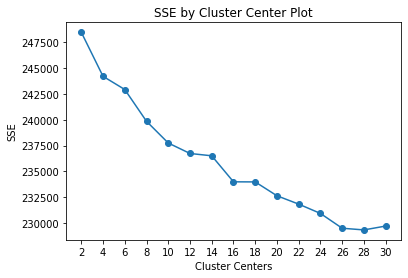

In [36]:
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(text, 30)

In [42]:
clusters = MiniBatchKMeans(n_clusters=20, init_size=1024, batch_size=2048, random_state=20).fit_predict(text)

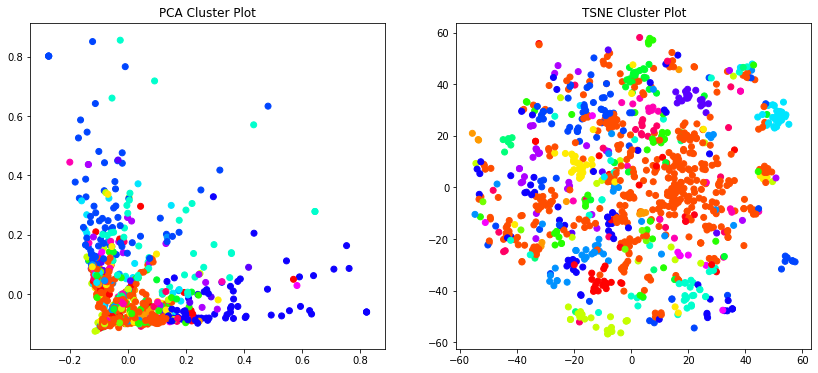

In [38]:
def plot_tsne_pca(data, labels):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=3000, replace=False)
    
    pca = PCA(n_components=2).fit_transform(data[max_items,:].todense())
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data[max_items,:].todense()))
    
    
    idx = np.random.choice(range(pca.shape[0]), size=1000, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')
    
plot_tsne_pca(text, clusters)

In [39]:
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
            

### Look at Pros

In [40]:
get_top_keywords(text, clusters, tfidf.get_feature_names(), 12)


Cluster 0
working,hours,friendly,great,place,pay,coworkers,benefits,environment,good,people,nice

Cluster 1
team,culture,management,opportunity,lot,working,employees,get,good,benefits,people,great

Cluster 2
plenty,lot,move,pay,good,benefits,lots,grow,great,advancement,growth,room

Cluster 3
flexible,hours,sick,full,pay,part,great,good,paid,benefits,vacation,time

Cluster 4
management,friendly,coworkers,working,school,pay,benefits,great,good,hours,schedule,flexible

Cluster 5
challenging,learn,fun,pay,benefits,people,good,great,pace,environment,paced,fast

Cluster 6
lot,move,grow,learning,good,advancement,benefits,growth,many,lots,great,opportunities

Cluster 7
plan,vacation,tuition,dental,matching,good,great,insurance,match,health,benefits,401k

Cluster 8
culture,world,working,good,industry,great,people,place,ever,benefits,one,best

Cluster 9
training,ok,coworkers,excellent,people,hours,competitive,decent,great,benefits,good,pay

Cluster 10
excellent,salary,environment,pay,people,cul

In [560]:
np.unique(clusters, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32),
 array([ 6496, 47021,  5995, 10740,  1180,  8942,  4859,  9140,  4345,
         3155]))

### Look at Cons

In [43]:
get_top_keywords(text, clusters, tfidf.get_feature_names(), 10)
np.unique(clusters, return_counts=True)


Cluster 0
complain,much,good,great,negative,really,think,bad,say,nothing

Cluster 1
hard,good,management,difficult,long,poor,hours,worklife,life,balance

Cluster 2
customers,service,unrealistic,meet,management,customer,high,pressure,goals,sales

Cluster 3
things,meetings,get,managers,employees,layers,changes,management,people,many

Cluster 4
development,little,lack,opportunity,room,limited,career,advancement,opportunities,growth

Cluster 5
good,job,cant,time,working,great,really,dont,think,cons

Cluster 6
middle,people,communication,senior,bad,lack,employees,poor,upper,management

Cluster 7
high,hard,management,weekends,pay,days,sometimes,working,hours,long

Cluster 8
sales,high,management,long,sometimes,hours,job,times,environment,stressful

Cluster 9
like,working,managers,think,good,lot,job,people,employees,none

Cluster 10
get,angry,deal,management,customer,dealing,employees,sometimes,rude,customers

Cluster 11
large,career,sometimes,big,decision,process,change,moving,growth,slow



(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19], dtype=int32),
 array([  3518,   6488,   6882,   9709,   8443,   5179,  19554,   6330,
          2927, 108791,   6045,   5308,   7314,  16358,  10268,   4802,
          7937,   4440,   8804,   9261]))

### Calculate highest/lowest % companies per cluster

In [44]:
# clusters array gives us cluster category per order of review in our dataframe
print(len(clusters))
clusters[:20] # preview
data['cluster'] = clusters # make a new column in our OG dataframe

258358


In [45]:
data.head()

,company,cons,pros,rating,title,cluster
0,Sysco,no flexibility micromanage no room for growth.,good benefits nice values nice co workers nice...,3.0,could be better,4
1,Sysco,its a lot of manual labor,its great pay amp steady work,5.0,great place to work,9
2,Sysco,appreciation for good work is no longer celebr...,great worklife balance limitless income potential,3.0,typical corporate company.,9
3,Sysco,customers will call 7 days a week and nights t...,money benefits flexibility of schedule great u...,4.0,marketing associate,10
4,Sysco,with the recent layoffs lacks stability,excellent benefits competitive within the market,5.0,hr specialist,9


In [48]:
# function that displays normalized top/bottom companies per cluster category
def show_company_counts():
    
    # add cluster column to DF
    data['cluster'] = clusters
    
    # multiindex series with review counts per company per cluster
    grouped = data.groupby(['cluster','company']).title.count()
    
    # series of total reviews per company
    total_counts = data.groupby('company').title.count()
    
    # multiindex DF resulting from joining above series together
    final_grouped = pd.merge(grouped.reset_index(), total_counts.reset_index(), on=['company'], how='inner').set_index(['cluster','company'])
    
    # adding a column for normalized reviews: reviews per cluster/total number of reviews
    final_grouped['normalized'] = final_grouped['title_x']/final_grouped['title_y']
    
    # return DF sorted by cluster and normalized value
    return final_grouped.sort_values(by=['cluster','normalized'], ascending = [True,False])

show_company_counts()

title_x  title_y  normalized
cluster company                                              
0       Google                       355     9600    0.036979
        HP                            55     1710    0.032164
        John Deere                    57     1808    0.031527
        Booking.com                   21     1000    0.021000
        Ford                          21     1000    0.021000
        Nike                          52     2490    0.020884
        Apple                         20     1000    0.020000
        Delta Airlines                33     1680    0.019643
        JP Morgan                    357    18463    0.019336
        Cisco                         30     1680    0.017857
        Enterprise Products            4      227    0.017621
        Facebook                      24     1407    0.017058
        Nationwide                    34     2010    0.016915
        Humana                        30     1880    0.015957
        AbbVie                        10      627    0.015949
        Microsoft                    314    20638    0.015215
        Walmart                       15      999    0.015015
        Costco                        15     1000    0.015000
        Tech Data                     11      744    0.014785
        General Electric              91     6182    0.014720
        Cigna                         29     2000    0.014500
        Coca Cola                     36     2490    0.014458
        American Express              29     2010    0.014428
        Publix                        31     2180    0.014220
        Cardinal Health               27     2026    0.013327
        AT&T                          13     1000    0.013000
        Walt Disney                   26     2000    0.013000
        Bank of America              276    21564    0.012799
        Progressive                   29     2300    0.012609
        General Motors                16     1270    0.012598
        Fannie Mae                    14     1112    0.012590
        Fedex                         25     2000    0.012500
        Wells Fargo                  281    22613    0.012426
        PepsiCo                       22     1800    0.012222
        American Airlines             24     1970    0.012183
        Chevron                       12     1000    0.012000
        Lockheed Martin               24     2000    0.012000
        Pfizer                        23     1990    0.011558
        AmerisourceBergen             10      909    0.011001
        McKesson                      11     1000    0.011000
        Best Buy                      22     2010    0.010945
        Verizon Wireless             207    19137    0.010817
        Archer Daniels                 7      648    0.010802
        Caterpillar                   19     1760    0.010795
        General Dynamics              22     2054    0.010711
        3M                            19     1782    0.010662
        Centene                       11     1041    0.010567
        Prudential                     6      580    0.010345
        HCA Healthcare                19     1864    0.010193
        United Technologies            7      693    0.010101
        Amazon                        10     1000    0.010000
        Home Depot                   113    11834    0.009549
        Intel                         16     1680    0.009524
        Morgan Stanley                19     2000    0.009500
        Walgreens                    141    15063    0.009361
        Kroger                        90     9667    0.009310
        Goldman Sachs                 23     2490    0.009237
        UPS                           18     1960    0.009184
        Comcast                       78     8558    0.009114
        Merck                         18     2000    0.009000
        New York Life Insurance       12     1360    0.008824
        AIG                           11     1290    0.008527
        Albertsons                    13     1528    0.008508
   

In [397]:
def show_top_companies(cluster_array):
    df = pd.DataFrame(columns = np.unique(cluster_array))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19


# LDA Modeling

In [151]:
import glob
import pandas as pd
import nltk
from gensim import corpora
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models.ldamodel import LdaModel

In [6]:
# read in all .csv files in our data folder
path = '../data/'
files = [f for f in glob.glob(path + "**/*.csv", recursive=True)]

li = [pd.read_csv(f) for f in files]
all_reviews = pd.concat(li, axis=0, ignore_index=True, sort=True) # sort=True b/c columns are in diff orders per df
all_reviews = all_reviews.drop(columns = ['Unnamed: 0','Unnamed: 0.1'])
all_reviews = all_reviews.dropna()

In [152]:
all_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258358 entries, 0 to 258357
Data columns (total 5 columns):
company    258358 non-null object
cons       258358 non-null object
pros       258358 non-null object
rating     258358 non-null float64
title      258258 non-null object
dtypes: float64(1), object(4)
memory usage: 9.9+ MB


### Look at Pros

In [192]:
# stemmed_pros_list = stemmed_pros.apply(lambda x: join_word_list(x))
# punc_remove = stemmed_pros_list.values.tolist()
pros_remove = all_reviews['pros'].values.tolist()

In [193]:
pros_remove = [' '.join(w for w in word.split() if w not in (['work', 'company', 'home', 'depot', 'verizon', 'boa', 'bank', 'america', 'boeing', 'comcast', 'ge', 'google', 'jp', 'morgan', 'microsoft', 'kroger', 'walgreens', 'wells', 'fargo'] + list(stopwords.words('english')))) for word in pros_remove]

pros_remove = [tokenize_sentences(word) for word in pros_remove]
# pros_remove = tokenized_pros.apply(lambda x: [word for word in x if word not in (custom_stopwords+['work','company'])])

In [659]:
# # OPTIONAL: STEMMING
# stemmed_pros = []
# for sentence in pros_remove:
#     stemmed_sentence = [stemmer.stem(word) for word in sentence]
#     stemmed_pros.append(stemmed_sentence)

# dictionary_pros = corpora.Dictionary(stemmed_pros)

# pros_corpus = [dictionary_pros.doc2bow(text) for text in stemmed_pros]

In [194]:
dictionary_pros = corpora.Dictionary(pros_remove)

pros_corpus = [dictionary_pros.doc2bow(text) for text in pros_remove]

In [183]:
# Pros Output
ldamodel = LdaModel(corpus = pros_corpus, num_topics=20, id2word = dictionary_pros, 
                                           passes=10, random_state = 25, minimum_probability = 0.0)



# from gensim.test.utils import datapath
# # save model
# temp_file = datapath("lda_stemmed_pros_20")
# ldamodel.save(temp_file)
# # assign doc_topics

In [169]:
# OPTIONAL: STEMMING
lda_stemmed_pros_20 = LdaModel.load(datapath("lda_stemmed_pros_20"))
doc_topics_pros = list(lda_stemmed_pros_20.get_document_topics(pros_corpus))

# Examine topic clusters

lda_stemmed_pros_20.show_topics(num_topics = 20, num_words = 13) # remove index to show all topics

IndexError: index 27878 is out of bounds for axis 1 with size 27878

In [173]:
lda_pros_20 = LdaModel.load(datapath("lda_pros_20"))
doc_topics_pros = list(lda_pros_20.get_document_topics(pros_corpus))

# Examine topic clusters

lda_pros_20.show_topics(num_topics = 20, num_words = 13) # remove index to show all topics

[(0,
  '0.053*"training" + 0.037*"leadership" + 0.037*"development" + 0.034*"management" + 0.029*"strong" + 0.025*"culture" + 0.025*"interesting" + 0.025*"level" + 0.024*"values" + 0.023*"support" + 0.020*"program" + 0.020*"programs" + 0.019*"plenty"'),
 (1,
  '0.196*"place" + 0.078*"work" + 0.039*"people" + 0.036*"start" + 0.027*"cool" + 0.025*"think" + 0.022*"talented" + 0.021*"career" + 0.020*"generally" + 0.019*"meet" + 0.018*"need" + 0.017*"role" + 0.017*"plus"'),
 (2,
  '0.142*"opportunities" + 0.082*"lots" + 0.061*"opportunity" + 0.055*"many" + 0.054*"growth" + 0.043*"career" + 0.040*"move" + 0.039*"within" + 0.036*"different" + 0.033*"advancement" + 0.027*"grow" + 0.027*"large" + 0.025*"company"'),
 (3,
  '0.113*"time" + 0.081*"benefits" + 0.071*"k" + 0.057*"health" + 0.041*"paid" + 0.040*"vacation" + 0.038*"insurance" + 0.032*"part" + 0.027*"bonus" + 0.026*"days" + 0.024*"year" + 0.021*"medical" + 0.021*"pto"'),
 (4,
  '0.119*"lot" + 0.102*"job" + 0.098*"learn" + 0.076*"experi

In [184]:
# results without 'great', 'good'
ldamodel.show_topics(num_topics = 20, num_words = 13) # remove index to show all topics

[(0,
  '0.113*"lot" + 0.092*"learn" + 0.068*"new" + 0.037*"place" + 0.035*"better" + 0.035*"things" + 0.034*"people" + 0.028*"youre" + 0.022*"get" + 0.020*"skills" + 0.020*"long" + 0.018*"would" + 0.015*"could"'),
 (1,
  '0.189*"people" + 0.128*"environment" + 0.104*"working" + 0.076*"smart" + 0.055*"benefits" + 0.040*"compensation" + 0.039*"flexibility" + 0.034*"culture" + 0.031*"perks" + 0.027*"diversity" + 0.022*"positive" + 0.022*"fair" + 0.013*"scheduling"'),
 (2,
  '0.130*"salary" + 0.086*"competitive" + 0.069*"benefits" + 0.038*"location" + 0.031*"industry" + 0.028*"companies" + 0.026*"bonus" + 0.023*"building" + 0.021*"structure" + 0.018*"area" + 0.018*"commission" + 0.017*"compared" + 0.016*"especially"'),
 (3,
  '0.131*"opportunity" + 0.072*"amazing" + 0.057*"interesting" + 0.056*"challenging" + 0.053*"projects" + 0.043*"plenty" + 0.042*"people" + 0.027*"wonderful" + 0.026*"potential" + 0.026*"benefits" + 0.022*"growth" + 0.017*"develop" + 0.017*"technical"'),
 (4,
  '0.352*"

In [195]:
# should try without 'great', 'good' words
lda_pros_20 = LdaModel.load(datapath("lda_pros_20"))
doc_topics_pros = list(lda_pros_20.get_document_topics(pros_corpus))

# Examine topic clusters

lda_pros_20.show_topics(num_topics = 20, num_words = 13)

[(0,
  '0.053*"training" + 0.037*"leadership" + 0.037*"development" + 0.034*"management" + 0.029*"strong" + 0.025*"culture" + 0.025*"interesting" + 0.025*"level" + 0.024*"values" + 0.023*"support" + 0.020*"program" + 0.020*"programs" + 0.019*"plenty"'),
 (1,
  '0.196*"place" + 0.078*"work" + 0.039*"people" + 0.036*"start" + 0.027*"cool" + 0.025*"think" + 0.022*"talented" + 0.021*"career" + 0.020*"generally" + 0.019*"meet" + 0.018*"need" + 0.017*"role" + 0.017*"plus"'),
 (2,
  '0.142*"opportunities" + 0.082*"lots" + 0.061*"opportunity" + 0.055*"many" + 0.054*"growth" + 0.043*"career" + 0.040*"move" + 0.039*"within" + 0.036*"different" + 0.033*"advancement" + 0.027*"grow" + 0.027*"large" + 0.025*"company"'),
 (3,
  '0.113*"time" + 0.081*"benefits" + 0.071*"k" + 0.057*"health" + 0.041*"paid" + 0.040*"vacation" + 0.038*"insurance" + 0.032*"part" + 0.027*"bonus" + 0.026*"days" + 0.024*"year" + 0.021*"medical" + 0.021*"pto"'),
 (4,
  '0.119*"lot" + 0.102*"job" + 0.098*"learn" + 0.076*"experi

In [584]:
# try to get an idea of what each topic is
all_reviews.loc[:,['company','rating','pros','topic_pros_19']].sort_values(by = ['topic_pros_19'], ascending=False).iloc[0:100]

,company,rating,pros,topic_pros_19
212911,Lowe's,3.0,average average average average average,0.841666
246832,PepsiCo,3.0,you can go as far as you push yourself to go.,0.809997
174212,JP Morgan,3.0,better than other it companies around.,0.762499
191442,Microsoft,2.0,there are now better companies in the seattle ...,0.762499
86599,Google,3.0,same as other companies around this area.,0.762499
145917,Bank of America,3.0,access to upper management as mentors,0.762498
19725,Verizon Wireless,2.0,come and go as you please,0.762493
230330,Boeing,4.0,layoff rate is lower than some other companies.,0.762492
177324,JP Morgan,5.0,5 star company follows 5 star standard,0.762483
5024,Enterprise Products,4.0,better than some oilfield companies,0.683332


### Summarizing and Labeling Topics:
- 0: Training and development programs
- 1: "Cool" people & place to work at the start of your career
- 2: High potential for growth and advancement
- 3: Good benefits: 401k, health/medical insurance, pto, vacation, bonus
- 4: Great learning opportunity and skills development
- 5: Rewarded for good work (caring managers, bonuses)
- 6: Good pay, reimbursement for expenses, flexible hours
- 7: Challenging, fast-paced, strive for excellence
- 8: Help and customer-oriented
- 9: No pros
- 10: Superior products/industry
- 11: Work-life balance, flexible schedule
- 12: ? throwaway topic
- 13: Friendly,helpful people and work environment
- 14: High quality, exciting projects and smart people
- 15: ? Great pay, culture, benefits
- 16: ? "Love" working there
- 17: Free amenities: free food, discounts, events, gym, education
- 18: People like "family." Best company, best brand. Always new things.
- 19: Better than other similar companies, competitors

### Outlier Analysis

In [196]:
doc_topics = list(lda_pros_20.get_document_topics(pros_corpus))

all_reviews['doc_topic_pros'] = doc_topics

all_reviews['doc_topic_pros'] = all_reviews['doc_topic_pros'].map(lambda x: dict(x))

for topic_num in range(20):
    all_reviews[f'topic_pros_{topic_num}'] = all_reviews['doc_topic_pros'].apply(lambda x: x.get(topic_num, 0))

In [197]:
# Preview table
round(all_reviews.groupby('company').mean().iloc[:,1:21],3)*100

,topic_pros_0,topic_pros_1,topic_pros_2,topic_pros_3,topic_pros_4,topic_pros_5,topic_pros_6,topic_pros_7,topic_pros_8,topic_pros_9,topic_pros_10,topic_pros_11,topic_pros_12,topic_pros_13,topic_pros_14,topic_pros_15,topic_pros_16,topic_pros_17,topic_pros_18,topic_pros_19
company,,,,,,,,,,,,,,,,,,,,
3M,6.2,3.2,7.6,3.5,4.9,3.2,9.5,3.6,2.9,3.5,5.1,5.4,2.9,6.9,4.3,8.1,2.4,2.9,4.9,3.2
AIG,4.7,3.6,6.4,8.1,4.3,3.1,10.6,3.1,2.9,4.3,3.3,7.3,2.9,6.3,3.6,8.9,2.1,2.3,4.1,2.1
AT&T,4.3,3.0,6.0,5.7,3.7,2.6,17.3,3.5,4.3,3.1,2.9,3.9,2.7,3.4,2.3,11.4,2.7,5.3,3.3,2.5
AbbVie,6.2,3.0,6.0,4.5,3.9,3.7,8.6,3.1,2.8,3.4,4.9,7.7,3.2,8.4,3.9,9.9,1.9,2.1,3.9,3.0
Albertsons,3.6,3.4,4.1,4.7,4.7,3.6,14.2,4.6,7.2,5.2,2.0,2.2,3.0,7.9,2.6,6.6,2.6,3.7,5.2,3.0
Amazon,4.9,3.5,6.0,5.6,4.6,2.7,12.7,5.6,4.8,3.8,2.7,3.0,3.0,6.0,4.2,7.5,3.5,2.6,4.9,3.1
American Airlines,3.2,2.7,4.8,6.3,4.2,2.9,10.9,3.3,3.8,4.2,2.9,3.9,2.8,5.0,2.7,12.7,6.7,3.4,5.4,2.7
American Express,5.6,2.8,6.6,4.8,3.8,3.3,9.3,2.5,2.6,3.2,2.9,10.8,2.9,6.3,3.5,11.3,2.6,2.8,4.5,1.9
AmerisourceBergen,4.2,3.1,6.1,6.3,3.7,3.7,12.6,3.7,3.1,4.4,3.1,3.7,3.0,7.6,3.1,9.9,2.5,3.4,4.8,2.3


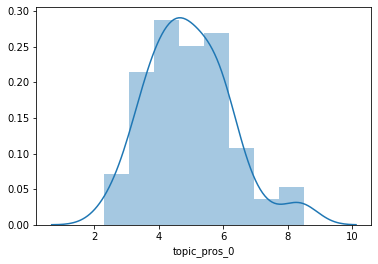

In [198]:
import seaborn as sns
dist_pros = round(all_reviews.groupby('company').mean().iloc[:,1:21],3)*100
sns.distplot(dist_pros['topic_pros_0'])

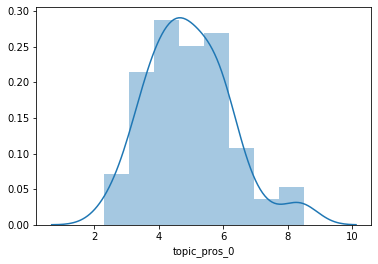

In [516]:
# graph distributions: some are right-skewed
import seaborn as sns
dist_pros = round(all_reviews.groupby('company').mean().iloc[:,1:21],3)*100
sns.distplot(dist_pros['topic_pros_0'])

In [199]:
from scipy import stats
for i in range(0,20):
    test_result = stats.ttest_1samp(dist_pros[f'topic_pros_{i}'].values, 100/15)
    if test_result[1] > 0.05:
        print(f'topic {i}: ', f't-stat: {test_result[0]}', f'p-value: {test_result[1]}', 'NOT SIGNIFICANT')
    else:
        print(f'topic {i}: ', f't-stat: {test_result[0]}', f'p-value: {test_result[1]}')

topic 0:  t-stat: -11.481529479680923 p-value: 7.62102919221544e-18
topic 1:  t-stat: -62.85280488284789 p-value: 5.527556851890385e-64
topic 2:  t-stat: -3.289984089870008 p-value: 0.001561681901432706
topic 3:  t-stat: -9.067046178907912 p-value: 1.7652588516523355e-13
topic 4:  t-stat: -25.88353258250428 p-value: 6.887169700121702e-38
topic 5:  t-stat: -57.396361627534816 p-value: 3.086149374855271e-61
topic 6:  t-stat: 14.19228312567914 p-value: 2.02727609452824e-22
topic 7:  t-stat: -34.084850646887524 p-value: 9.56246866220234e-46
topic 8:  t-stat: -21.320628279089227 p-value: 1.3889359454106693e-32
topic 9:  t-stat: -41.2536240905256 p-value: 2.3720554414117624e-51
topic 10:  t-stat: -31.914005058131057 p-value: 7.709974461003681e-44
topic 11:  t-stat: -4.73552573886137 p-value: 1.0856008495673527e-05
topic 12:  t-stat: -78.06260402094868 p-value: 1.42839949461175e-70
topic 13:  t-stat: 0.14412181939753935 p-value: 0.885812575608282 NOT SIGNIFICANT
topic 14:  t-stat: -23.4819362

In [200]:
# chi-2 test to test if topic distributions within a single company are equally distributed ~6.67
from scipy.stats import chisquare
for i in range(0,len(dist_pros.index)):
    test_result = chisquare(dist_pros.iloc[i])
    if test_result[1] > 0.05:
        print(f'{dist_pros.index[i]}: ', f'chi-2 stat: {test_result[0]}', f'p-value: {test_result[1]}', 'NOT SIGNIFICANT')
    else:
        print(f'{dist_pros.index[i]}: ', f'chi-2 stat: {test_result[0]}', f'p-value: {test_result[1]}')

3M:  chi-2 stat: 16.313800424628443 p-value: 0.6362491338029617 NOT SIGNIFICANT
AIG:  chi-2 stat: 23.863829787234042 p-value: 0.20142763393169225 NOT SIGNIFICANT
AT&T:  chi-2 stat: 52.27891373801916 p-value: 6.0091428305279445e-05
AbbVie:  chi-2 stat: 21.75759829968119 p-value: 0.2964858166100155 NOT SIGNIFICANT
Albertsons:  chi-2 stat: 30.70552603613177 p-value: 0.04347825790908371
Amazon:  chi-2 stat: 21.458394931362196 p-value: 0.3120334349624056 NOT SIGNIFICANT
American Airlines:  chi-2 stat: 29.52751322751322 p-value: 0.05812792129438192 NOT SIGNIFICANT
American Express:  chi-2 stat: 32.04680851063829 p-value: 0.03087745639212661
AmerisourceBergen:  chi-2 stat: 28.026617179215272 p-value: 0.08291770833850368 NOT SIGNIFICANT
Apple:  chi-2 stat: 37.24051172707888 p-value: 0.007402938904158481
Archer Daniels:  chi-2 stat: 26.122057264050902 p-value: 0.12682375835940457 NOT SIGNIFICANT
Bank of America:  chi-2 stat: 27.224123273113705 p-value: 0.09953999331959044 NOT SIGNIFICANT
Best B

In [201]:
# results without 'great', 'good'
# find outliers by locating values: Q1 < 1.5*IQR or Q3 > 1.5*IQR
from scipy.stats import iqr

for i in range(0,20):
    s = dist_pros[f'topic_pros_{i}']
    IQR = iqr(dist_pros[f'topic_pros_{i}'])
    below = s[s<(s.quantile(.25)-IQR)].sort_values(ascending=True)
    above = s[s>(s.quantile(.75)+IQR)].sort_values(ascending=False)
    print(f'topic_pros_{i}: ', above, '\n')

topic_pros_0:  company
New York Life Insurance    8.5
General Electric           8.4
Proctor & Gamble           8.2
Name: topic_pros_0, dtype: float64 

topic_pros_1:  company
Tech Data        5.0
Google           4.3
Intel            4.2
Goldman Sachs    4.2
Name: topic_pros_1, dtype: float64 

topic_pros_2:  company
General Electric    10.0
Name: topic_pros_2, dtype: float64 

topic_pros_3:  company
Humana    8.5
Name: topic_pros_3, dtype: float64 

topic_pros_4:  company
Morgan Stanley      6.3
Archer Daniels      6.3
Goldman Sachs       6.1
General Electric    6.0
Name: topic_pros_4, dtype: float64 

topic_pros_5:  company
Costco            4.8
Delta Airlines    4.7
Liberty Mutual    4.3
HCA Healthcare    4.3
Name: topic_pros_5, dtype: float64 

topic_pros_6:  company
Costco                 17.6
UPS                    17.4
AT&T                   17.3
Enterprise Products    16.8
Name: topic_pros_6, dtype: float64 

topic_pros_7:  company
Facebook                   5.7
Amazon        

In [526]:
# find outliers by locating values: Q1 < 1.5*IQR or Q3 > 1.5*IQR
from scipy.stats import iqr

for i in range(0,20):
    s = dist_pros[f'topic_pros_{i}']
    IQR = iqr(dist_pros[f'topic_pros_{i}'])
    below = s[s<(s.quantile(.25)-IQR)].sort_values(ascending=True)
    above = s[s>(s.quantile(.75)+IQR)].sort_values(ascending=False)
    print(f'topic_pros_{i}: ', above, '\n')

topic_pros_0:  company
New York Life Insurance    8.5
General Electric           8.4
Proctor & Gamble           8.2
Name: topic_pros_0, dtype: float64 

topic_pros_1:  company
Tech Data        5.0
Google           4.3
Intel            4.2
Goldman Sachs    4.2
Name: topic_pros_1, dtype: float64 

topic_pros_2:  company
General Electric    10.0
Name: topic_pros_2, dtype: float64 

topic_pros_3:  company
Humana    8.5
Name: topic_pros_3, dtype: float64 

topic_pros_4:  company
Morgan Stanley      6.3
Archer Daniels      6.3
Goldman Sachs       6.1
General Electric    6.0
Name: topic_pros_4, dtype: float64 

topic_pros_5:  company
Costco            4.8
Delta Airlines    4.7
Liberty Mutual    4.3
HCA Healthcare    4.3
Name: topic_pros_5, dtype: float64 

topic_pros_6:  company
Costco                 17.6
UPS                    17.4
AT&T                   17.3
Enterprise Products    16.8
Name: topic_pros_6, dtype: float64 

topic_pros_7:  company
Facebook                   5.7
Amazon        

### Look at Cons

In [527]:
cons_remove = all_reviews['cons'].values.tolist()

In [528]:
cons_remove = [' '.join(w for w in word.split() if w not in (['work', 'company', 'home', 'depot', 'verizon', 'boa', 'bank', 'america', 'boeing', 'comcast', 'ge', 'google', 'jp', 'morgan', 'microsoft', 'kroger', 'walgreens', 'wells', 'fargo']  + list(stopwords.words('english')))) for word in cons_remove]

cons_remove = [tokenize_sentences(word) for word in cons_remove]

In [665]:
# OPTIONAL: STEMMING
stemmed_cons = []
for sentence in cons_remove:
    stemmed_sentence = [stemmer.stem(word) for word in sentence]
    stemmed_cons.append(stemmed_sentence)

dictionary_cons = corpora.Dictionary(stemmed_cons)

cons_corpus = [dictionary_cons.doc2bow(text) for text in stemmed_cons]

In [699]:
dictionary_cons = corpora.Dictionary(cons_remove)

cons_corpus = [dictionary.doc2bow(text) for text in cons_remove]

In [700]:
# Cons Output
ldamodel_cons = LdaModel(corpus = cons_corpus, num_topics=20, id2word = dictionary_cons, 
                                           passes=10, random_state = 25, minimum_probability=0.0)

# save model
temp_file = datapath("lda_cons_20")
ldamodel_cons.save(temp_file)

In [669]:
lda_stemmed_cons_20 = LdaModel.load(datapath("lda_stemmed_cons_20"))
# assign doc_topics
doc_topics_cons = list(lda_stemmed_cons_20.get_document_topics(cons_corpus))
# Examine topic clusters
lda_stemmed_cons_20.show_topics(num_topics = 20, num_words = 13) # remove index to show all topics

[(0,
  '0.148*"custom" + 0.070*"sale" + 0.046*"servic" + 0.035*"expect" + 0.034*"goal" + 0.030*"meet" + 0.030*"product" + 0.025*"make" + 0.024*"sell" + 0.024*"number" + 0.023*"deal" + 0.019*"unrealist" + 0.017*"money"'),
 (1,
  '0.062*"hard" + 0.051*"sometim" + 0.050*"move" + 0.041*"get" + 0.037*"difficult" + 0.027*"big" + 0.026*"like" + 0.025*"posit" + 0.025*"depart" + 0.022*"locat" + 0.022*"feel" + 0.018*"compani" + 0.017*"depend"'),
 (2,
  '0.057*"year" + 0.035*"employe" + 0.019*"posit" + 0.018*"one" + 0.016*"month" + 0.015*"hire" + 0.015*"job" + 0.014*"even" + 0.013*"everi" + 0.012*"leav" + 0.011*"new" + 0.010*"work" + 0.009*"depart"'),
 (3,
  '0.183*"hour" + 0.088*"long" + 0.061*"day" + 0.058*"schedul" + 0.042*"time" + 0.036*"week" + 0.036*"work" + 0.033*"shift" + 0.020*"enough" + 0.020*"weekend" + 0.017*"overtim" + 0.015*"flexibl" + 0.015*"expect"'),
 (4,
  '0.080*"polit" + 0.075*"opportun" + 0.073*"advanc" + 0.062*"career" + 0.053*"slow" + 0.042*"limit" + 0.039*"growth" + 0.031*

In [701]:
lda_cons_20 = LdaModel.load(datapath("lda_cons_20"))
# assign doc_topics
doc_topics_cons = list(lda_cons_20.get_document_topics(cons_corpus))
# Examine topic clusters
lda_cons_20.show_topics(num_topics = 20, num_words = 13) # remove index to show all topics

[(0,
  '0.023*"get" + 0.021*"one" + 0.019*"people" + 0.016*"job" + 0.015*"even" + 0.012*"dont" + 0.012*"manager" + 0.012*"go" + 0.011*"youre" + 0.010*"want" + 0.010*"make" + 0.010*"time" + 0.010*"never"'),
 (1,
  '0.171*"hours" + 0.101*"long" + 0.039*"time" + 0.033*"schedule" + 0.033*"working" + 0.031*"enough" + 0.030*"day" + 0.030*"days" + 0.029*"week" + 0.019*"shift" + 0.014*"weekends" + 0.014*"hour" + 0.013*"busy"'),
 (2,
  '0.131*"store" + 0.081*"environment" + 0.071*"think" + 0.064*"none" + 0.052*"retail" + 0.039*"changing" + 0.030*"cant" + 0.025*"competitive" + 0.023*"driven" + 0.019*"toxic" + 0.018*"corporation" + 0.018*"constantly" + 0.016*"overall"'),
 (3,
  '0.085*"great" + 0.082*"good" + 0.066*"really" + 0.058*"cons" + 0.048*"nothing" + 0.039*"place" + 0.026*"bad" + 0.024*"isnt" + 0.022*"say" + 0.021*"best" + 0.021*"much" + 0.020*"everything" + 0.020*"learn"'),
 (4,
  '0.075*"sales" + 0.070*"customer" + 0.042*"service" + 0.033*"expectations" + 0.031*"customers" + 0.031*"goal

### Summarzing and labeling each topic:

### 20 Topics:
- 0: ? throwaway topic
- 1: Long work hours, weekend shifts
- 2: No cons
- 3: No cons
- 4: Unrealistic sales goals. Lofty expectations.
- 5: Incompetent managers, focused on metrics.
- 6: Office politics, red tape, a lot of "manager influence"
- 7: Not treated well or respected
- 8: Lack of leadership, poor management, limited communication
- 9: Bureaucratic, big company, Hierarchy, protocols. "small fish in a big pond."
- 10: Limited career opportunities/advancement, growth, work life balance.
- 11: Too many processes, procedures, meetings. Too formalized.
- 12: Lack of development path, training, support.
- 13: Frequent change and layoffs
- 14: Lack of care for employees from upper management
- 15: Difficult scheduling, working outside
- 16: ? throwaway topic
- 17: Low salary, limited benefits, lack of promotion
- 18: High stress, micromanagement, turnover
- 19: Had to advance from a lower level position, especially from part time to full time

### 20 Topics (Stemmed):
- 0: Too much concern around pushing sales, meeting goals. Intensity.
- 1: Hard to advance, move up. Small impact. Hierarchy of a big company.
- 2: Long time for promotion, things to happen.
- 3: Long hours, overworked. Sometimes working on weekends.
- 4: Limited advancement - but due to politics, bureaucracy, large organization (combine with 1?)
- 5: No cons
- 6: Frustrations of reaching full time positions from part time. (Home Depot, Delta, Publix, Costco)
- 7: Lack of job security, constant structural changes, layoffs. Cost-cutting, contract-based.
- 8: Insufficient annual raises, bonuses. Increases not based on performance. Inadequate promotion system - require heavy workload. Or not distributed fairly.
- 9: Strict, corporate environment. A lot of policies.
- 10: ? Call center environment. Being on call. A lot of demands.
- 11: No work life balance (combine with 3?)
- 12: Low salary - espec. compared to similar companies
- 13: Poor mgmt, communication from leadership. Micromanagement.
- 14: ? No cons and other random topics. Throwaway.
- 15: Lack of training, support. Inadequate technology.
- 16: High stress, pressure environment. Competitive, high expectations/metrics. Turnover.
- 17: ? "Could be better" category - throwaway
- 18: Lack of care for employees from management.
- 19: A lot of management influence (many layers of mgmt, success dependent on mgmt)

### 15 Topics:
- 0: ? throwaway topic
- 2: High pressure environment, stressful, high turnover
- 3: No cons
- 4: Unrealistic sales goals. Lofty expectations.
- 5: Sales over customer service.
        -Rude customers
- 6: Office politics, red tape, a lot of "manager influence"
- 7: Lack of care for employees from management
- 8: Lack of leadership, poor management, limited communication
- 9: Bureaucratic, big company, Hierarchy, protocols. "small fish in a big pond."
- 10: Limited career opportunities, growth, work life balance.
- 11: Boring
- 12: Hard to get things done. Slow. Large company.
- 13: Frequent change and layoffs
- 14: Low compensation, benefits, salary

### Outlier Analysis

In [670]:
all_reviews['doc_topic_cons'] = doc_topics_cons

all_reviews['doc_topic_cons'] = all_reviews['doc_topic_cons'].map(lambda x: dict(x))

for topic_num in range(20):
    all_reviews[f'topic_cons_{topic_num}'] = all_reviews['doc_topic_cons'].apply(lambda x: x.get(topic_num, 0))

In [599]:
# Perhaps chi-squared test?
dist_cons = round(all_reviews.groupby('company').mean().iloc[:,-20:],3)*100
# preview
round(all_reviews.groupby('company').mean().iloc[:,-20:],3)*100

,topic_cons_0,topic_cons_1,topic_cons_2,topic_cons_3,topic_cons_4,topic_cons_5,topic_cons_6,topic_cons_7,topic_cons_8,topic_cons_9,topic_cons_10,topic_cons_11,topic_cons_12,topic_cons_13,topic_cons_14,topic_cons_15,topic_cons_16,topic_cons_17,topic_cons_18,topic_cons_19
company,,,,,,,,,,,,,,,,,,,,
3M,8.9,3.2,2.7,4.6,2.9,3.2,3.2,4.6,7.8,8.5,4.7,5.3,5.1,3.8,4.9,4.2,6.9,5.8,2.8,6.7
AIG,8.2,2.9,3.1,3.9,3.0,3.3,3.1,4.6,8.9,5.5,4.4,4.4,5.9,7.7,4.6,3.2,8.3,7.4,3.2,4.5
AT&T,10.0,6.2,3.5,5.0,5.6,3.2,2.8,4.6,7.4,4.1,5.8,4.4,3.4,6.6,5.7,3.1,4.0,4.0,4.8,5.7
AbbVie,7.4,3.9,3.1,4.8,2.5,3.7,3.4,5.1,7.2,8.7,6.7,5.0,5.2,3.8,4.2,4.5,7.2,4.6,3.5,5.5
Albertsons,12.8,10.1,4.1,5.5,2.9,2.9,2.2,5.8,6.4,2.7,3.3,3.8,3.7,3.2,6.9,2.6,3.7,6.8,4.2,6.5
Amazon,9.8,11.3,3.4,6.4,3.3,3.0,2.5,6.5,4.7,3.4,5.1,4.2,3.9,3.9,4.3,3.3,4.0,4.4,4.7,7.9
American Airlines,9.6,9.0,3.2,6.5,2.2,3.2,2.5,5.1,5.9,3.6,3.6,4.3,3.5,4.6,6.8,3.5,4.5,7.8,3.8,6.9
American Express,8.5,3.8,3.7,5.2,3.3,3.5,4.0,4.6,6.4,7.2,5.0,4.6,4.9,5.2,3.9,3.5,6.7,6.4,3.6,6.2
AmerisourceBergen,11.6,5.7,2.7,4.9,2.2,3.3,2.7,6.4,8.6,4.3,5.3,4.4,6.1,4.1,4.9,2.7,5.4,5.6,3.8,5.3


In [698]:
# try to get an idea of what each topic is
all_reviews.loc[:,['company','rating','cons','topic_cons_19']].sort_values(by = ['topic_cons_19'], ascending=False).iloc[0:500]

,company,rating,cons,topic_cons_19
59261,Wells Fargo,5.0,so many layers of managements. long decision m...,0.881249
170231,JP Morgan,4.0,the business is depended on the market not goo...,0.881248
180744,JP Morgan,3.0,the organization has different lines of busine...,0.881248
165169,JP Morgan,5.0,management experiences may vary depending on t...,0.881248
58351,Wells Fargo,5.0,be sure you work for a good manager. the manag...,0.881245
153421,Bank of America,4.0,not much i see however some more clarity in te...,0.881244
192732,Microsoft,4.0,new gm with entitlement attitude a practicing ...,0.881244
741,Sysco,3.0,run from the top down without a clear understa...,0.881243
191408,Microsoft,4.0,too many hoops to jump through to actually mak...,0.881243
201129,Microsoft,5.0,some line managers are behind curve on authent...,0.881237


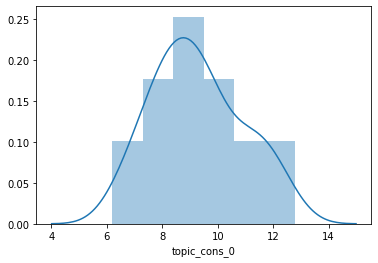

In [600]:
# graph distributions: some are right-skewed
import seaborn as sns
sns.distplot(dist_cons['topic_cons_0'])

In [601]:
# test topic distribution means across all companies are statistically significant from the expected value of: ~6.67
from scipy import stats
for i in range(0,20):
    test_result = stats.ttest_1samp(dist_cons[f'topic_cons_{i}'].values, 100/15)
    if test_result[1] > 0.05:
        print(f'topic {i}: ', f't-stat: {test_result[0]}', f'p-value: {test_result[1]}', 'NOT SIGNIFICANT')
    else:
        print(f'topic {i}: ', f't-stat: {test_result[0]}', f'p-value: {test_result[1]}')

topic 0:  t-stat: 13.621821987239823 p-value: 1.724685902528709e-21
topic 1:  t-stat: -0.9947108873981519 p-value: 0.32325494066774474 NOT SIGNIFICANT
topic 2:  t-stat: -43.389273082589256 p-value: 7.540032854214066e-53
topic 3:  t-stat: -10.166903151263467 p-value: 1.7065187098475546e-15
topic 4:  t-stat: -22.517977694473455 p-value: 4.69959328605072e-34
topic 5:  t-stat: -92.80782679099217 p-value: 7.432135385595226e-76
topic 6:  t-stat: -48.10408603592228 p-value: 6.309219790452031e-56
topic 7:  t-stat: -15.711396610549347 p-value: 8.295872519091573e-25
topic 8:  t-stat: 0.04403035792463026 p-value: 0.9650038040476254 NOT SIGNIFICANT
topic 9:  t-stat: -4.841911281180754 p-value: 7.274963193461135e-06
topic 10:  t-stat: -16.352110549853464 p-value: 8.904956747269916e-26
topic 11:  t-stat: -33.349544149809624 p-value: 4.1119719398376e-45
topic 12:  t-stat: -22.16069520667929 p-value: 1.2724339496634066e-33
topic 13:  t-stat: -17.39477138021719 p-value: 2.6260376419093747e-27
topic 14:

In [550]:
# chi-2 test to test if topic distributions within a single company are equally distributed ~6.67
from scipy.stats import chisquare
for i in range(0,len(dist_cons.index)):
    test_result = chisquare(dist_cons.iloc[i])
    if test_result[1] > 0.05:
        print(f'{dist_cons.index[i]}: ', f'chi-2 stat: {test_result[0]}', f'p-value: {test_result[1]}', 'NOT SIGNIFICANT')
    else:
        print(f'{dist_cons.index[i]}: ', f'chi-2 stat: {test_result[0]}', f'p-value: {test_result[1]}')

3M:  chi-2 stat: 15.131863727454911 p-value: 0.3692004636256572 NOT SIGNIFICANT
AIG:  chi-2 stat: 25.28016032064128 p-value: 0.03190023660181739
AT&T:  chi-2 stat: 12.675075075075075 p-value: 0.5522528970232395 NOT SIGNIFICANT
AbbVie:  chi-2 stat: 13.639039039039037 p-value: 0.47693437253407833 NOT SIGNIFICANT
Albertsons:  chi-2 stat: 28.87627627627628 p-value: 0.010860485471961326
Amazon:  chi-2 stat: 20.24564564564565 p-value: 0.12258505696363749 NOT SIGNIFICANT
American Airlines:  chi-2 stat: 19.189221556886228 p-value: 0.15784426762042642 NOT SIGNIFICANT
American Express:  chi-2 stat: 12.767000000000003 p-value: 0.5449468532041237 NOT SIGNIFICANT
AmerisourceBergen:  chi-2 stat: 25.12552552552552 p-value: 0.03334820721275855
Apple:  chi-2 stat: 12.356886227544909 p-value: 0.5776656506496551 NOT SIGNIFICANT
Archer Daniels:  chi-2 stat: 15.058341658341657 p-value: 0.37417818102699407 NOT SIGNIFICANT
Bank of America:  chi-2 stat: 11.590781563126253 p-value: 0.6391289148199563 NOT SIGNI

In [602]:
# find outliers by locating values: Q1 < 1.5*IQR or Q3 > 1.5*IQR
from scipy.stats import iqr

for i in range(0,20):
    s = dist_cons[f'topic_cons_{i}']
    IQR = iqr(dist_cons[f'topic_cons_{i}'])
    below = s[s<(s.quantile(.25)-IQR)].sort_values(ascending=True)
    above = s[s>(s.quantile(.75)+IQR)].sort_values(ascending=False)
    print(f'topic_{i}: ', above, '\n')

topic_0:  Series([], Name: topic_cons_0, dtype: float64) 

topic_1:  Series([], Name: topic_cons_1, dtype: float64) 

topic_2:  company
Apple       5.8
Nike        5.3
Facebook    4.8
Best Buy    4.8
Name: topic_cons_2, dtype: float64 

topic_3:  company
Google            9.2
John Deere        7.6
Delta Airlines    7.5
Nike              7.4
HP                7.4
Facebook          7.3
Costco            7.2
Apple             6.9
Name: topic_cons_3, dtype: float64 

topic_4:  company
Wells Fargo                9.5
New York Life Insurance    7.3
Best Buy                   6.4
Comcast                    6.1
AT&T                       5.6
Verizon Wireless           5.5
Bank of America            5.5
Sysco                      4.8
Progressive                4.2
Name: topic_cons_4, dtype: float64 

topic_5:  company
Microsoft      4.0
Phillips 66    3.9
Facebook       3.9
Name: topic_cons_5, dtype: float64 

topic_6:  company
Exelon              6.7
American Express    4.0
Name: topic_cons_6, 

# NMF Modeling

In [55]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize

vectorizer = CountVectorizer(analyzer = "word", max_features = 10_000)

pros_remove = all_reviews.pros.tolist()
pros_remove_tokenized = [tokenize_sentences(text) for text in pros_remove]
pros_remove_stopwords = [remove_stopwords(token) for token in pros_remove_tokenized]

pros_joined = [' '.join(text) for text in pros_remove_stopwords]

pros_joined = pros_joined
word_counts = vectorizer.fit_transform(pros_joined)

tfidf_transform = TfidfTransformer(smooth_idf = False)

words_tfidf = tfidf_transform.fit_transform(word_counts)

# final_words = normalize(words_tfidf, norm = 'l1')

KeyboardInterrupt: 

In [52]:
model = NMF(n_components = 15, init = 'nndsvd')

W = model.fit_transform(words_tfidf)

W.shape

H = model.components_

H.shape

lst = []

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        lst.append(message)
    return lst

topics_nmf = (print_top_words(model, vectorizer.get_feature_names(), 10))



nmfsplit = [item.split() for item in topics_nmf]

pd.DataFrame(nmfsplit)

,0,1,2,3,4,5,6,7,8,9,10,11
0,Topic,#0:,great,coworkers,team,management,training,atmosphere,experience,products,perks,leadership
1,Topic,#1:,good,salary,management,training,experience,money,pretty,benefit,team,atmosphere
2,Topic,#2:,balance,life,work,worklife,flexibility,compensation,excellent,decent,family,salary
3,Topic,#3:,company,work,large,big,within,employees,stable,move,best,well
4,Topic,#4:,people,smart,work,meet,worked,lot,working,really,talented,friendly
5,Topic,#5:,flexible,hours,schedule,working,management,friendly,school,schedules,scheduling,coworkers
6,Topic,#6:,opportunities,lots,growth,career,opportunity,advancement,lot,learn,many,training
7,Topic,#7:,pay,decent,competitive,ok,starting,average,hours,overtime,well,benefits
8,Topic,#8:,environment,working,friendly,team,fun,work,fast,professional,positive,paced
9,Topic,#9:,work,place,home,best,fun,hard,interesting,challenging,awesome,learn


### Look at Cons

In [56]:
vectorizer = CountVectorizer(analyzer = "word", max_features = 10_000)

cons_remove = all_reviews.cons.tolist()
cons_remove_tokenized = [tokenize_sentences(text) for text in cons_remove]
cons_remove_stopwords = [remove_stopwords(token) for token in cons_remove_tokenized]

cons_joined = [' '.join(text) for text in cons_remove_stopwords]

cons_joined = cons_joined
word_counts = vectorizer.fit_transform(cons_joined)

tfidf_transform = TfidfTransformer(smooth_idf = False)

words_tfidf = tfidf_transform.fit_transform(word_counts)

In [57]:
model = NMF(n_components = 15, init = 'nndsvd')

W = model.fit_transform(words_tfidf)

W.shape

H = model.components_

H.shape

lst = []

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        lst.append(message)
    return lst

topics_nmf = (print_top_words(model, vectorizer.get_feature_names(), 10))



nmfsplit = [item.split() for item in topics_nmf]

pd.DataFrame(nmfsplit)

,0,1,2,3,4,5,6,7,8,9,10,11
0,Topic,#0:,people,dont,employees,job,many,get,managers,like,good,know
1,Topic,#1:,cons,dont,think,really,working,great,cant,find,place,job
2,Topic,#2:,work,environment,place,great,load,weekends,holidays,life,schedule,stressful
3,Topic,#3:,hours,long,working,retail,sometimes,enough,week,days,weekends,holidays
4,Topic,#4:,none,think,cant,great,really,moment,far,could,place,anything
5,Topic,#5:,pay,low,better,could,salary,benefits,enough,competitive,little,great
6,Topic,#6:,management,poor,upper,lack,communication,bad,employees,senior,middle,horrible
7,Topic,#7:,company,big,large,great,within,slow,move,bureaucracy,lost,difficult
8,Topic,#8:,nothing,bad,say,really,good,think,negative,great,everything,anything
9,Topic,#9:,much,growth,room,career,opportunities,advancement,slow,limited,politics,opportunity


In [215]:
all_reviews.groupby('company').count()

,cons,pros,rating,title,doc_topic_pros,topic_pros_0,topic_pros_1,topic_pros_2,topic_pros_3,topic_pros_4,topic_pros_5,topic_pros_6,topic_pros_7,topic_pros_8,topic_pros_9,topic_pros_10,topic_pros_11,topic_pros_12,topic_pros_13,topic_pros_14,topic_pros_15,topic_pros_16,topic_pros_17,topic_pros_18,topic_pros_19
company,,,,,,,,,,,,,,,,,,,,,,,,,
3M,1782,1782,1782,1782,1782,1782,1782,1782,1782,1782,1782,1782,1782,1782,1782,1782,1782,1782,1782,1782,1782,1782,1782,1782,1782
AIG,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290
AT&T,1000,1000,1000,998,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
AbbVie,627,627,627,627,627,627,627,627,627,627,627,627,627,627,627,627,627,627,627,627,627,627,627,627,627
Albertsons,1528,1528,1528,1527,1528,1528,1528,1528,1528,1528,1528,1528,1528,1528,1528,1528,1528,1528,1528,1528,1528,1528,1528,1528,1528
Amazon,1000,1000,1000,999,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
American Airlines,1970,1970,1970,1970,1970,1970,1970,1970,1970,1970,1970,1970,1970,1970,1970,1970,1970,1970,1970,1970,1970,1970,1970,1970,1970
American Express,2010,2010,2010,2010,2010,2010,2010,2010,2010,2010,2010,2010,2010,2010,2010,2010,2010,2010,2010,2010,2010,2010,2010,2010,2010
AmerisourceBergen,909,909,909,908,909,909,909,909,909,909,909,909,909,909,909,909,909,909,909,909,909,909,909,909,909
